# Generating synthetic data

## Import libraries

In [1]:
# basic essential libraries
import matplotlib.pyplot as plt
import numpy as np
import os

# libraries for displaying images and videos
import cv2
import copy
from IPython.display import HTML
import io
import base64

# pose estimation library
from pytorch_openpose.src import model
from pytorch_openpose.src import util
from pytorch_openpose.src.body import Body

## Define functions

In [2]:
def draw_pose(candidate, subset, width=1200, height=800):
    '''
    Draw training data poses on a black canvas
        Inputs -
            candidate: list of x and y coordinates for openpose keypoints
            subset: list of scores for keypoint detection of each subject in openpose
            width: width of black canvas
            height: height of black canvas
        Outputs -
            Image of pose drawn on a black background
    '''
    # initialise white image
    img = np.zeros([height, width, 3],dtype=np.uint8)
    
    # draw poses
    canvas = copy.deepcopy(img)
    canvas = util.draw_bodypose(canvas, candidate, subset)
    
    # display plot
    fig, axes = plt.subplots(1,1, figsize=(15,7.5))
    plt.imshow(canvas[:, :, [2, 1, 0]])
    plt.axis('off')
    plt.show()
    
def gen_syn_data(feature_dir, delay_ms, width=1200, n=0):
    '''
    Choose subject n in video and replicate with delay. Randomly shuffles order of fastest dancer.
        Inputs -
                feature_dir: path to openpose features
                delay_ms: maximum delay between dancers in ms
                width: total width that dancers should cover
                n: reference subject
        Outputs -
                Saves a new feature npz file as 
                '<video id>_<reference subject>_<position of fastest subject>_<delay in ms>.npz'
                'index.npz' is created as a dictionary of video paths and their corresponding index
                candidate_1, candidate_2, candidate_3: x and y coordinates for keypoints per subject subject
                subset_1, subset_2, subset_3: scores for keypoints per subject
                mul_candidate: concatenated x and y subjects for all 3 subjects
                mul_subset: concatenated scores for keypoints for all 3 subjects
    '''    
    output_dir = 'synthetic_data/output'
    openpose_features = np.load(feature_dir, allow_pickle=True)
    try:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
    except OSError:
        print ('Error: Creating could not create output directory')
        
    # choose position ordering
    order = np.array([0,1,2])
    np.random.shuffle(order)

    # convert delay to frames and add random noise of up to 2 frames
    # assume frame rate of 25fps
    delay_frames_max = np.max([np.int(delay_ms/40) - np.random.randint(0,2), 0])
    if delay_frames_max == 0:
        delay_frames_int = 0
    else:
        delay_frames_int = np.random.randint(0,delay_frames_max)
    delay_diff_int = delay_frames_max - delay_frames_int
    delay = [0, delay_frames_int, delay_frames_max]

    # get positions
    pos_ref = np.where(order == 0)[0]
    pos_int = np.where(order == 1)[0]
    pos_max = np.where(order == 2)[0]

    # print final selection
    print('intialising with subject ' + str(n) + ': ')
    print('Delay settings (frames) - pos 1: ' + str(delay[order[0]]) + \
          ', pos 2: ' + str(delay[order[1]]) + ', pos 3: ' + str(delay[order[2]]))

    candidate_1 = []
    candidate_2 = []
    candidate_3 = []
    mul_candidate = []
    subset_1 = []
    subset_2 = []
    subset_3 = []
    mul_subset = []
    least_frame = 0
    c1_offset = np.random.randint(-50,50)
    c2_offset = np.random.randint(-50,50)
    c3_offset = np.random.randint(-50,50)
    
    for frame in range(len(openpose_features['subset_all'])):
        # initialise index
        idx = openpose_features['subset_all'][frame][n,:].astype(int)
        mean_x = np.mean(openpose_features['candidate_all'][frame][idx,0])
        # initialise reference subject
        candidate_1_adj = openpose_features['candidate_all'][frame][idx,:]
        candidate_1_adj[:,0] += (pos_ref + 1) * width/4 - mean_x + c1_offset # adjust position
        candidate_1.append(candidate_1_adj)
        lin_points = np.linspace(0, 19, num=20)
        lin_points[idx == -1] = -1
        subset_1.append(np.expand_dims(lin_points, axis=0))
        # initialise subject with intermediate delay 
        if frame >= delay_frames_int:
            candidate_2_adj = openpose_features['candidate_all'][frame][idx,:]
            candidate_2_adj[:,0] += ((pos_int + 1) * width/4 - mean_x) + c2_offset # adjust position
            candidate_2.append(candidate_2_adj)
            lin_points = np.linspace(0, 19, num=20)
            lin_points[idx == -1] = -1
            subset_2.append(np.expand_dims(lin_points, axis=0))
        # initialise subject with maximum delay
        if frame >= delay_frames_max:
            candidate_3_adj = openpose_features['candidate_all'][frame][idx,:]
            candidate_3_adj[:,0] += (pos_max + 1) * width/4 - mean_x + c3_offset # adjust position
            candidate_3.append(candidate_3_adj)
            lin_points = np.linspace(0, 19, num=20)
            lin_points[idx == -1] = -1
            subset_3.append(np.expand_dims(lin_points, axis=0))
            # initialise concatenated subjects
            mul_candidate.append(np.concatenate((candidate_1[least_frame], \
                                                 candidate_2[least_frame], candidate_3[least_frame])))
            subset_cat = np.concatenate((subset_1[least_frame], \
                                         subset_2[least_frame], subset_3[least_frame]),axis=1)
            lin_points = np.expand_dims(np.linspace(0, 59, num=60),axis=0)
            lin_points[subset_cat == -1] = -1
            mul_subset.append(lin_points.reshape(3,20))
            least_frame += 1
            
    # save index of videos
    if os.path.isfile(output_dir + '/index.npz'):
        print('loading existing video index...')
        # load npz
        vid_index = np.load(output_dir + '/index.npz')
        f_path = vid_index['f_path'].tolist()
        count_vid = vid_index['count_vid'].tolist()
        # check whether index exists
        flag = 0
        for idx in range(len(f_path)):
            if f_path[idx] == feature_dir:
                count = count_vid[idx]
                flag = 1
                continue
        # append to npz if it does not exist
        if flag == 0:
            f_path.append(feature_dir)
            count_vid.append(len(f_path) - 1)
            np.savez(output_dir + '/index', count_vid = count_vid, f_path = f_path)
    else:
        # create npz
        count_vid = []
        count = 0
        count_vid.append(count)
        f_path = []
        f_path.append(feature_dir)
        print('video index does not exist, creating...')
        np.savez(output_dir + '/index', count_vid = count_vid, f_path = f_path)
    
    # save final combined file
    np.savez(output_dir + '/vid' + "{0:03}".format(count) + '_sub' + str(n) + '_ref' + \
             str(pos_ref[0]) + '_delay' + str(delay_ms), candidate_all=mul_candidate, subset_all=mul_subset)
        
    return candidate_1, subset_1, candidate_2, subset_2, candidate_3, subset_3, mul_candidate, mul_subset

## Training example setup example
Grab features from an example video and show poses for frame 1

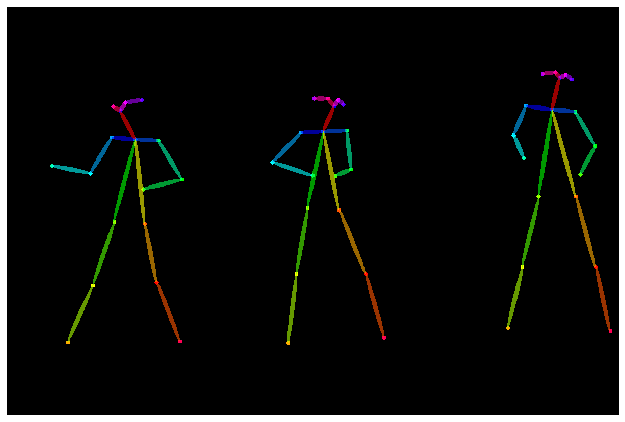

In [3]:
# load data
feature_dir = 'synthetic_data/Videos/video1/output_features/seg1/pose_features.npz'
openpose_features = np.load(feature_dir, allow_pickle=True)
# draw initial pose
draw_pose(openpose_features['candidate_all'][1], openpose_features['subset_all'][1])

Generate synthetic data and draw positions to check output

intialising with subject 0: 
Delay settings (frames) - pos 1: 24, pos 2: 23, pos 3: 0
loading existing video index...


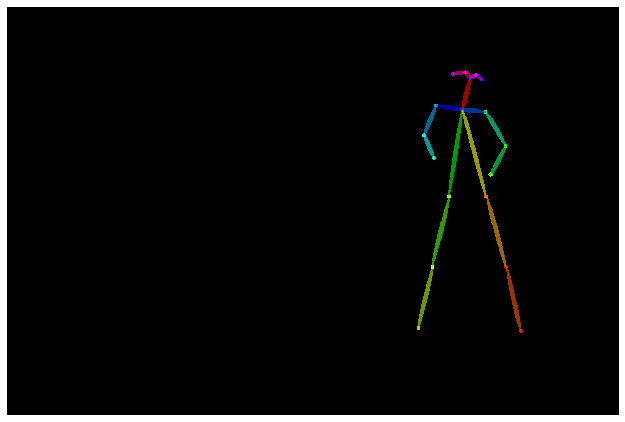

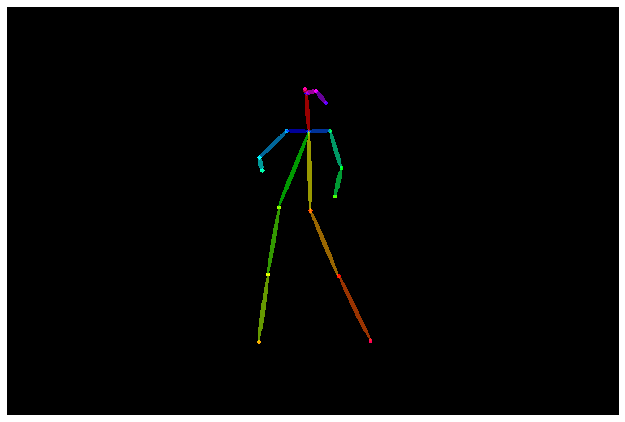

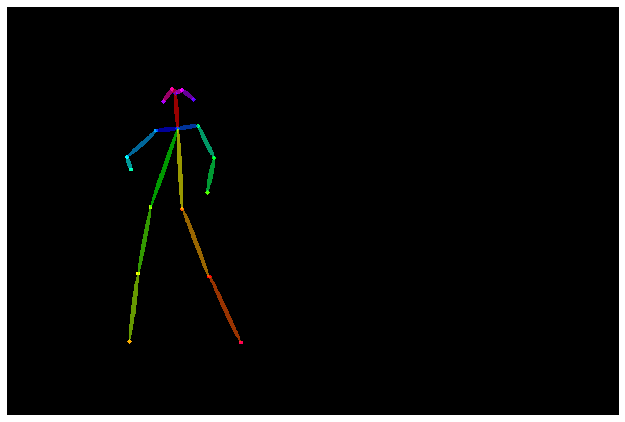

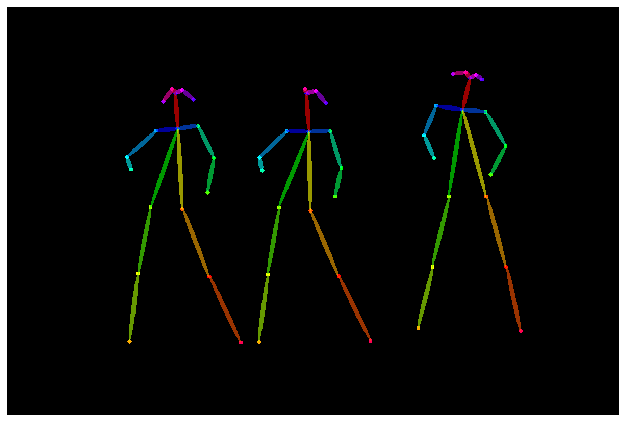

In [4]:
# generate synthetic data
candidate_1, subset_1, candidate_2, subset_2, candidate_3, subset_3, \
mul_candidate, mul_subset = gen_syn_data(feature_dir, 1000, 1200, 0)

# draw poses to check
draw_pose(candidate_1[1], subset_1[1])
draw_pose(candidate_2[1], subset_2[1])
draw_pose(candidate_3[1], subset_3[1])
draw_pose(mul_candidate[1], mul_subset[1])

## Iterate over videos
Specify video directory to loop over, for each segmented video, a random subject will be selected and delays from 50-1000ms will be created.

In [7]:
video = 5

data_dir = 'synthetic_data/Videos/video' + str(video) + '/output_features'
for filename in os.listdir(data_dir):
    if filename.startswith("seg"): 
        print('----------')
        feature_dir = data_dir + '/' + filename + '/pose_features.npz'
        print(feature_dir)
        for d in range(0,1001,50):
            try:
                _,_,_,_,_,_,_,_ = gen_syn_data(feature_dir, d, 1200, np.random.randint(3))
            except:
                print('ERROR in settings: check for occlusions, unusual openpose features')

----------
synthetic_data/Videos/video4/output_features/seg11/pose_features.npz
intialising with subject 0: 
Delay settings (frames) - pos 1: 0, pos 2: 0, pos 3: 0
loading existing video index...
ERROR in settings: check for occlusions, unusual openpose features
intialising with subject 2: 
Delay settings (frames) - pos 1: 0, pos 2: 0, pos 3: 0
loading existing video index...
intialising with subject 1: 
Delay settings (frames) - pos 1: 1, pos 2: 0, pos 3: 0
loading existing video index...
intialising with subject 0: 
Delay settings (frames) - pos 1: 1, pos 2: 3, pos 3: 0
loading existing video index...
intialising with subject 2: 
Delay settings (frames) - pos 1: 0, pos 2: 4, pos 3: 1
loading existing video index...
intialising with subject 1: 
Delay settings (frames) - pos 1: 0, pos 2: 6, pos 3: 4
loading existing video index...
intialising with subject 1: 
Delay settings (frames) - pos 1: 0, pos 2: 6, pos 3: 0
loading existing video index...
intialising with subject 0: 
Delay settin

loading existing video index...
intialising with subject 0: 
Delay settings (frames) - pos 1: 13, pos 2: 0, pos 3: 14
loading existing video index...
intialising with subject 0: 
Delay settings (frames) - pos 1: 0, pos 2: 2, pos 3: 16
loading existing video index...
intialising with subject 2: 
Delay settings (frames) - pos 1: 0, pos 2: 16, pos 3: 7
loading existing video index...
intialising with subject 2: 
Delay settings (frames) - pos 1: 0, pos 2: 14, pos 3: 17
loading existing video index...
intialising with subject 2: 
Delay settings (frames) - pos 1: 20, pos 2: 14, pos 3: 0
loading existing video index...
intialising with subject 0: 
Delay settings (frames) - pos 1: 21, pos 2: 0, pos 3: 18
loading existing video index...
intialising with subject 2: 
Delay settings (frames) - pos 1: 22, pos 2: 0, pos 3: 0
loading existing video index...
intialising with subject 2: 
Delay settings (frames) - pos 1: 8, pos 2: 0, pos 3: 22
loading existing video index...
intialising with subject 1: 

loading existing video index...
intialising with subject 1: 
Delay settings (frames) - pos 1: 0, pos 2: 19, pos 3: 9
loading existing video index...
intialising with subject 2: 
Delay settings (frames) - pos 1: 21, pos 2: 0, pos 3: 19
loading existing video index...
intialising with subject 2: 
Delay settings (frames) - pos 1: 21, pos 2: 0, pos 3: 22
loading existing video index...
intialising with subject 0: 
Delay settings (frames) - pos 1: 23, pos 2: 11, pos 3: 0
loading existing video index...
intialising with subject 1: 
Delay settings (frames) - pos 1: 24, pos 2: 0, pos 3: 11
loading existing video index...
----------
synthetic_data/Videos/video4/output_features/seg12/pose_features.npz
intialising with subject 0: 
Delay settings (frames) - pos 1: 0, pos 2: 0, pos 3: 0
loading existing video index...
ERROR in settings: check for occlusions, unusual openpose features
intialising with subject 1: 
Delay settings (frames) - pos 1: 0, pos 2: 0, pos 3: 0
loading existing video index...


loading existing video index...
intialising with subject 0: 
Delay settings (frames) - pos 1: 24, pos 2: 0, pos 3: 1
loading existing video index...
----------
synthetic_data/Videos/video4/output_features/seg2/pose_features.npz
intialising with subject 0: 
Delay settings (frames) - pos 1: 0, pos 2: 0, pos 3: 0
loading existing video index...
ERROR in settings: check for occlusions, unusual openpose features
intialising with subject 0: 
Delay settings (frames) - pos 1: 1, pos 2: 0, pos 3: 0
loading existing video index...
intialising with subject 1: 
Delay settings (frames) - pos 1: 0, pos 2: 2, pos 3: 0
loading existing video index...
intialising with subject 2: 
Delay settings (frames) - pos 1: 2, pos 2: 0, pos 3: 0
loading existing video index...
intialising with subject 0: 
Delay settings (frames) - pos 1: 0, pos 2: 4, pos 3: 0
loading existing video index...
intialising with subject 1: 
Delay settings (frames) - pos 1: 0, pos 2: 0, pos 3: 6
loading existing video index...
intialisi